<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Sentinel-1/-2 surface water monitoring"<br>
    description: "This is a tutorial within the fifth theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2023-09-12<br>
    authors: Andreas Mayr<br>
</details>

# Sentinel-1/-2 surface water monitoring

One of the key requirements for monitoring Earth surface processes by remote sensing is an adequate temporal resolution. In satellite remote sensing this is often limited by the satellites' revisit interval and (for optical imagery) by cloud cover. This Notebook shows how to combine data from two different sensor constellations, namely Sentinel-1 (S-1) and Sentinel-2 (S-2), for monitoring the spatial extent of surface water over a few months.

**Case study**

 With the [Grand Ethiopian Renaissance Dam (GERD)](https://en.wikipedia.org/wiki/Grand_Ethiopian_Renaissance_Dam) being constructed on the Blue Nile river in Ethiopia, filling of a large water reservoir for hydroelectric power production started in the year 2020. We will try to observe the surface water extent in the GERD reservoir area during the first filling phase in 2020. As the filling makes quite rapid progress during the rainy season (when clouds tend to obstruct the view for optical satellite sensors), we want to combine data from Sentinel-1 and -2 to keep track of the lake extent dynamics.

**Approach**

On the one hand, we will get a time series of Normalized Difference Water Index (NDWI) computed from Sentinel-2 optical bands in the Google Earth Engine (GEE). On the other hand, we will use a time series of Sentinel-1 Synthetic Aperture Radar (SAR) data from the GEE, more specifically this is C-band SAR Ground Range Detected (GRD) backscatter intensity. Learn more about SAR characteristics and Sentinel-1 (in general and in the GEE) [here](https://doi.org/10.1109/MGRS.2013.2248301) and [here](https://developers.google.com/earth-engine/tutorials/community/sar-basics).

Importantly, NDWI and SAR backscatter intensity are two very different quantities, so the datasets cannot easily be combined as they are. Hence, we will not directly fuse data from S-2 and S-1 and we will not try any normalization or similar (as it is, e.g., done to harmonize Sentinel-2 and Landsat spectral bands), instead we first apply a simple classification of water and non-water and then fuse the classified water time series. As water contrasts well with other surface types in both S-2 and S-1 features and the changes taking place are large, we can expect such a relatively simple approach to work reasonably well (but let's see ...).

**Software environment**

For GEE and `xarray` based raster time series processing we use the packages [geemap](https://geemap.org/), [wxee](https://wxee.readthedocs.io/en/latest/index.html) and [eemont](https://eemont.readthedocs.io/), which are contained in the requirements file provided for the course. Please see the instructions on the [software page](https://3dgeo-heidelberg.github.io/etrainee/software/software_python.html) for setting up a Conda environment based on this file.

Import packages, then authenticate and initialize Google Earth Engine.

In [3]:
import ee, eemont, wxee, geemap

In [4]:
try:
        wxee.Initialize()
except Exception as e:          # If initialize does not work, you probably have to authenticate first
        ee.Authenticate()
        wxee.Initialize()

## Area-of-interest

Define a bounding box with our area-of-interest (AOI) and a point (the center of the bounding box; both obtained from [bboxfinder]( http://bboxfinder.com/)).

In [5]:
bbox = ee.Geometry.BBox(35.023041,10.756414, 35.430908,11.263265)
poi = ee.Geometry.Point(35.226974,11.009612)

See the area on a map. To speed things up, we do not cover the entire reservoir area - feel free to change this.

In [6]:
bbox_gdf = geemap.ee_to_geopandas(ee.FeatureCollection(bbox)).set_crs(crs='EPSG:4326')
bbox_gdf.explore()

## Data search and preprocessing

### Sentinel-2

First, we query [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) optical satellite imagery for the time period and area we are interested in, conditioned by cloudy pixel percentage. We mask clouds and scale the reflectance values (using eemont's convenient `preprocess()` method), compute the Normalized Difference Water Index (NDWI; using [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/index.html) backing eemont), and select the NDWI as a band for download and further analysis.

We use the NDWI for open water features ([McFeeters 1996](https://doi.org/10.1080/01431169608948714)), not to be confused with the NDWI for vegetation water content estimation by [Gao (1996)](https://doi.org/10.1016/S0034-4257(96)00067-3). Alternatively you might try, e.g., the Sentinel-2 Water Index (SWI) by [Jiang et al. (2021)](https://doi.org/10.3390/w13121647).

In [7]:
S2 = (ee.ImageCollection("COPERNICUS/S2_SR")
      .filterBounds(poi)      # use the point-of-interest in the center of our AOI here
      .filterDate("2020-05-01","2020-10-31")
      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 30)
      .preprocess().spectralIndices("NDWI").select("NDWI"))
print(len(S2))                # number of images found

14


Convert GEE ImageCollection to wxee TimeSeries and have a look at the temporal distribution of the available images matching our search criteria (max. cloud cover etc.).

In [8]:
S2_ts = S2.wx.to_time_series()
S2_ts.timeline()

Download the wxee TimeSeries (load into memory as an xarray Dataset). We set the ``scale`` parameter to get a cell size of 100 m.

In [ ]:
S2_ds = S2_ts.wx.to_xarray(region=bbox, scale=100)

Show time series of NDWI maps.

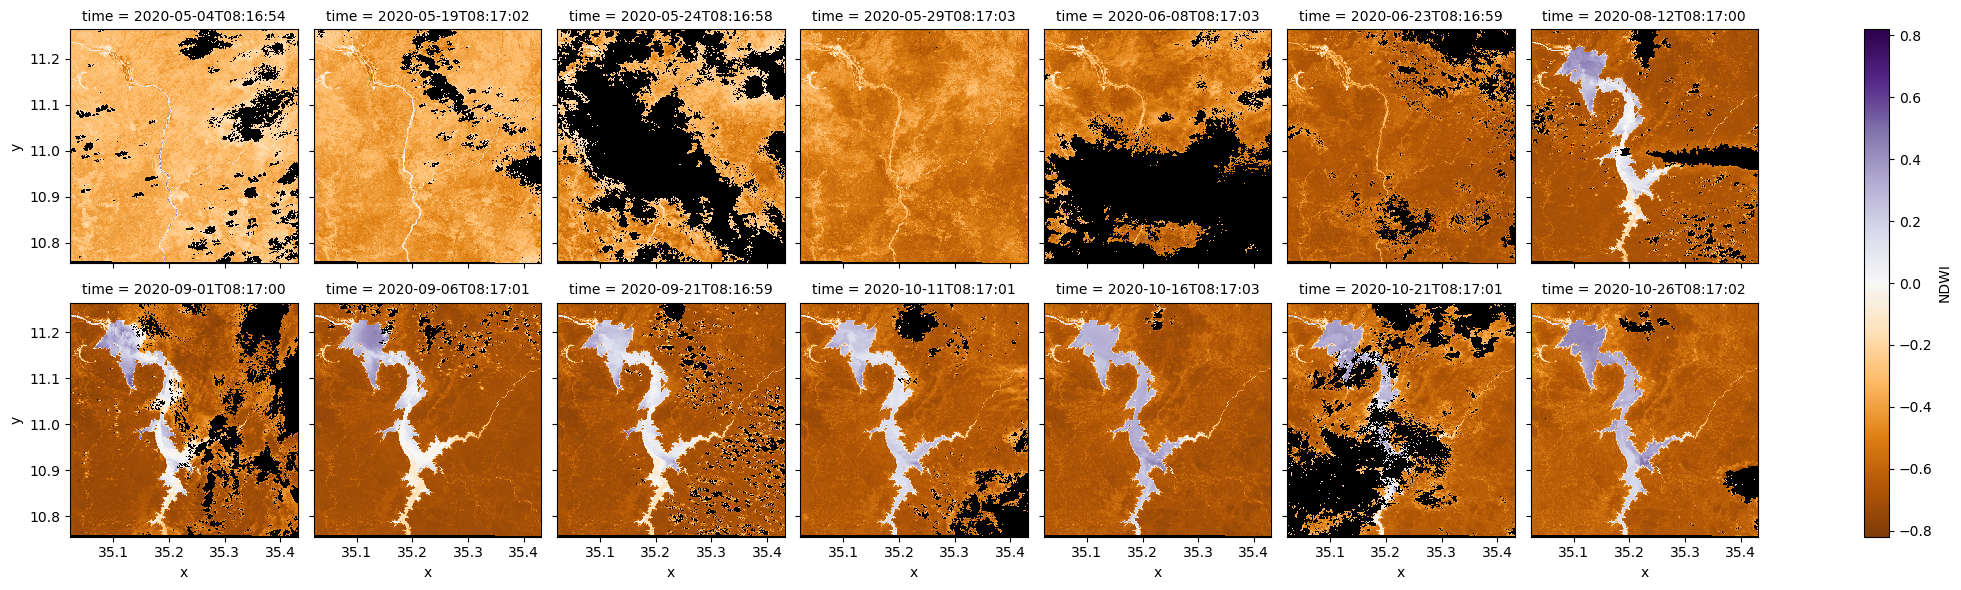

In [10]:
from matplotlib import colormaps

custom_cmap = colormaps.get_cmap('PuOr')    # Let's modify an existing colormap
custom_cmap.set_bad(color='black')          # Show NaNs in black
S2_ds.NDWI.plot(col='time', col_wrap=7, cmap=custom_cmap)

With water surfaces contrasting quite well with surrounding land surfaces, we can see a lake having emerged within the investigated time period. However, looking at the timeline plotted above the temporal resolution of our S-2 time series is quite heterogeneous (we have excluded imagery with 30% cloudy pixels or more). The largest gap is between 23 June and 12 August. In the time series of NDWI maps we see that filling of the reservoir mostly took place during this period (apparently the rainy season). Further data gaps in the downloaded imagery are shown in black, most likely as a result of cloud masking (and possibly a tile border in the very south).

### Sentinel-1

To overcome the apparent limitations of the optical image time series (but still use its information content), let's go for a data fusion approach including Sentinel-1 data, which is known to be much more robust towards clouds. We search and request [Sentinel-1 C-band SAR data](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) (Ground Range Detected, log-scaled), mostly similar to the procedure we used for S2. For simplicity, we select only the VV band (i.e., single co-polarization, vertical transmit/vertical receive).

In [11]:
S1 = (ee.ImageCollection("COPERNICUS/S1_GRD")
      .filterBounds(poi)
      .filterDate("2020-05-01","2020-10-31")
      .select("VV"))
print(len(S1))                # number of images found

14


Convert GEE ImageCollection to wxee TimeSeries. The temporal distribution of the available images is more homogeneous as we don't have the cloud cover restriction.

In [12]:
S1_ts = S1.wx.to_time_series()
S1_ts.timeline()

Download the wxee TimeSeries (load into memory as an xarray Dataset). We set the ``scale`` parameter to get a cell size of 100 m.

In [13]:
S1_ds = S1_ts.wx.to_xarray(region=bbox, scale=100)

Requesting data:   0%|          | 0/14 [00:00<?, ?it/s]

Show the VV polarization band backscatter intensity time series (unit is decibels).

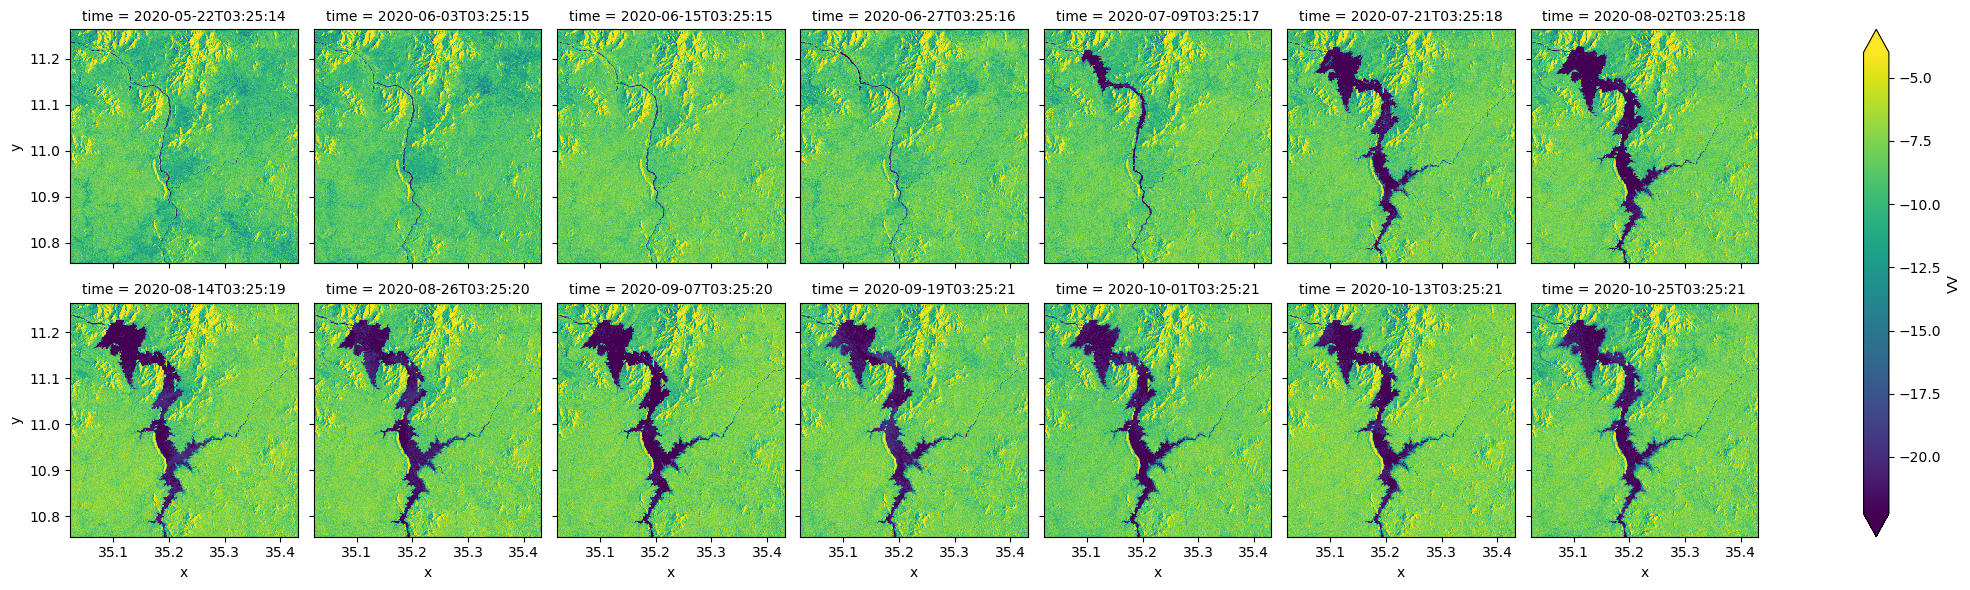

In [14]:
S1_ds.VV.plot(col='time', col_wrap=7, robust=True)

## Water surface classification

According to the map time series plots of NDWI and VV, both these features seem to be well suitable to discriminate surface water from surrounding land surface. Therefore, let's try a very simple classification approach, where we select a threshold for each of the two features and use this to reclassify pixels into 'water' and 'non-water'.

Plot the histograms for one S-2 scene and one S-1 scene where the lake is well visible. The thresholds we use in the next step are shown as dashed lines in the histograms. Of course, these values can be debated or optimized (by try-and-error or by data-driven approaches, such as clustering) but for now we just go on with them and reclassify the raster time series in the next step.

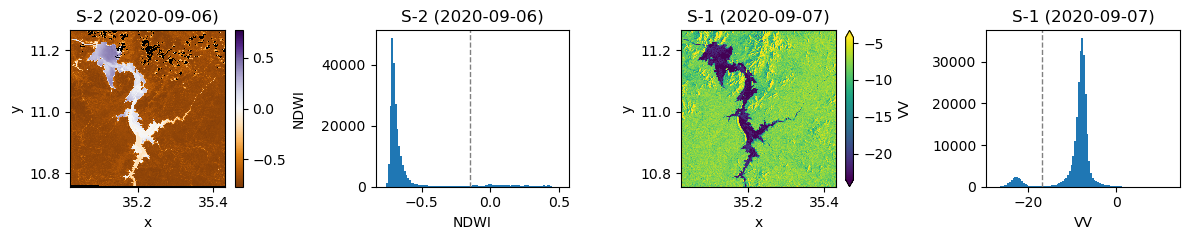

In [15]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1,4, figsize=(12,2.5))

S2_ds.NDWI.sel(time='2020-09-06').plot(cmap=custom_cmap, ax=axes[0])
axes[0].set_title('S-2 (2020-09-06)')

S2_ds.NDWI.sel(time='2020-09-06').plot.hist(bins=100, ax=axes[1]);
axes[1].axvline(-0.15, color='grey', linestyle='dashed', linewidth=1)
axes[1].set_title('S-2 (2020-09-06)')

S1_ds.VV.sel(time='2020-09-07').plot(robust=True, ax=axes[2])
axes[2].set_title('S-1 (2020-09-07)')

S1_ds.VV.sel(time='2020-09-07').plot.hist(bins=100, ax=axes[3]);
axes[3].axvline(-17.0, color='grey', linestyle='dashed', linewidth=1)
axes[3].set_title('S-1 (2020-09-07)');

fig.tight_layout()

Classify water in NDWI time series with the chosen threshold.

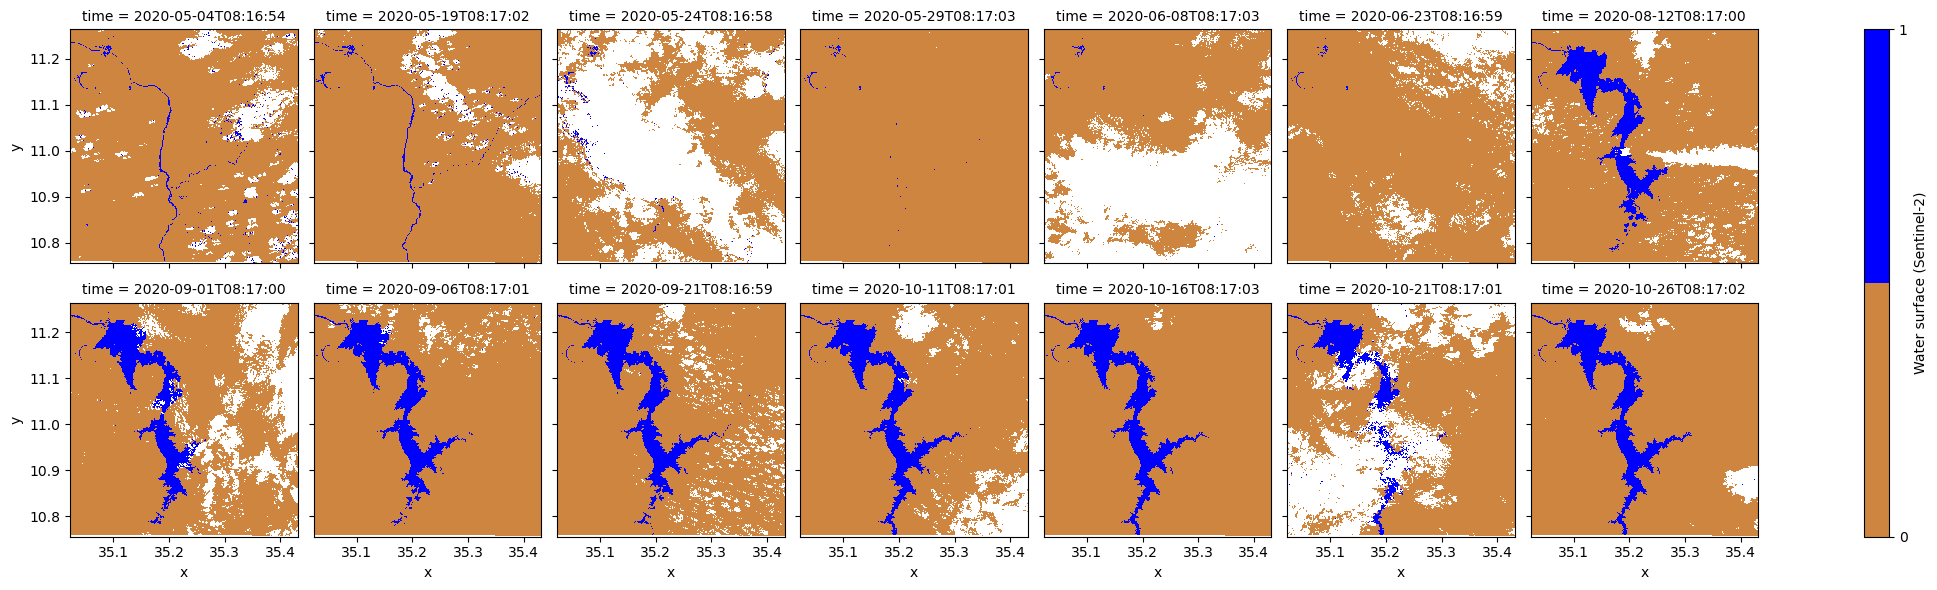

In [16]:
import numpy as np
import xarray as xr
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# In a new DataArray, set all pixels to 1 if their NDWI >= -0.15, keep the NDWI value for all other pixels
S2_water = xr.where(S2_ds.NDWI >= -0.15, 1, S2_ds.NDWI)

# Set all pixels to 1 if their NDWI < -0.15 and if they are not NaN, keep values otherwise
S2_water = xr.where((S2_water < -0.15) & (np.isnan(S2_water)==False), 0, S2_water)

S2_water.attrs = S2_ds.attrs                # Copy the attributes of the S2 Dataset (CRS, spatial res., ...)

# Let' plot
cmap = ListedColormap(['peru', 'blue'])
S2_water.plot(col='time', col_wrap=7, cbar_kwargs={'label': 'Water surface (Sentinel-2)', 'ticks': [0, 1]}, cmap=cmap)

Classify water in VV time series with the chosen threshold.

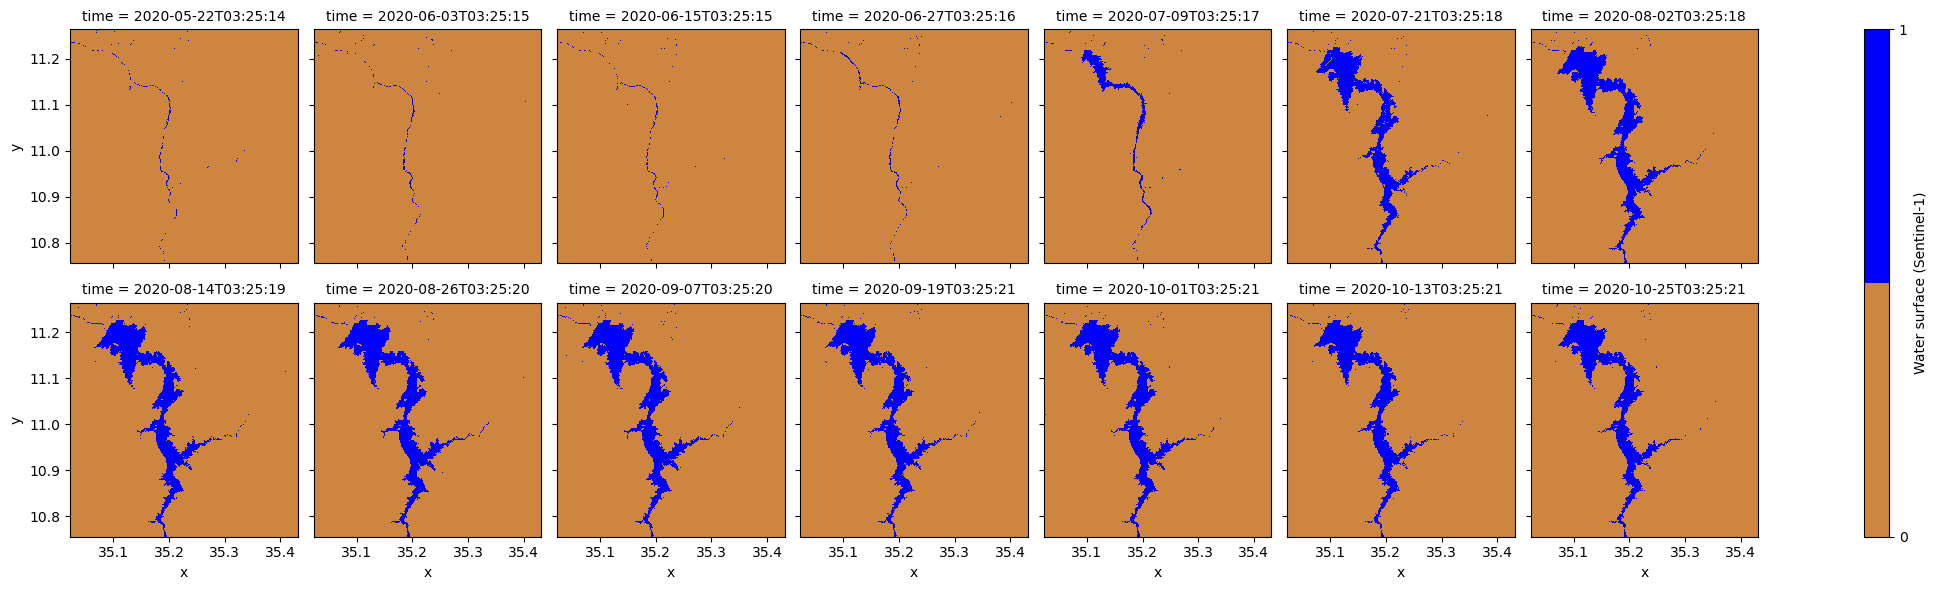

In [17]:
# In a new DataArray, set all pixels to 0 if their VV >= -17.0, keep the VV value for all other pixels
S1_water = xr.where(S1_ds.VV >= -17.0, 0, S1_ds.VV)

# Set all pixels to 1 if their VV < -17.0 and if they are not NaN, keep values otherwise
S1_water = xr.where((S1_water < -17.0) & (np.isnan(S1_water)==False), 1, S1_water)

S1_water.attrs = S1_ds.attrs                # Copy the attributes of the S2 Dataset (CRS, spatial res., ...)

# Let' plot
cmap = ListedColormap(['peru', 'blue'])
S1_water.plot(col='time', col_wrap=7, cbar_kwargs={'label': 'Water surface (Sentinel-1)', 'ticks': [0, 1]}, cmap=cmap)

## Combine the two water surface time series

Finally, we can combine the two two time series (*post-classification data fusion*) by concatenating them along the time dimension and sorting the new DataArray by time. An important prerequisite for this is that they "fit" in space and in time, i.e. in terms of CRS, grid system (bounds and cell size), and temporal reference system (calendar, time zone etc.). Moreover, the classification into common semantic target categories (*water*/*no-water*) is advantageous for most of the further analyses. <!--The colorbar label and tick labels are too small but this seems to be a bit complicated to change, see here: https://github.com/pydata/xarray/issues/3275 -->

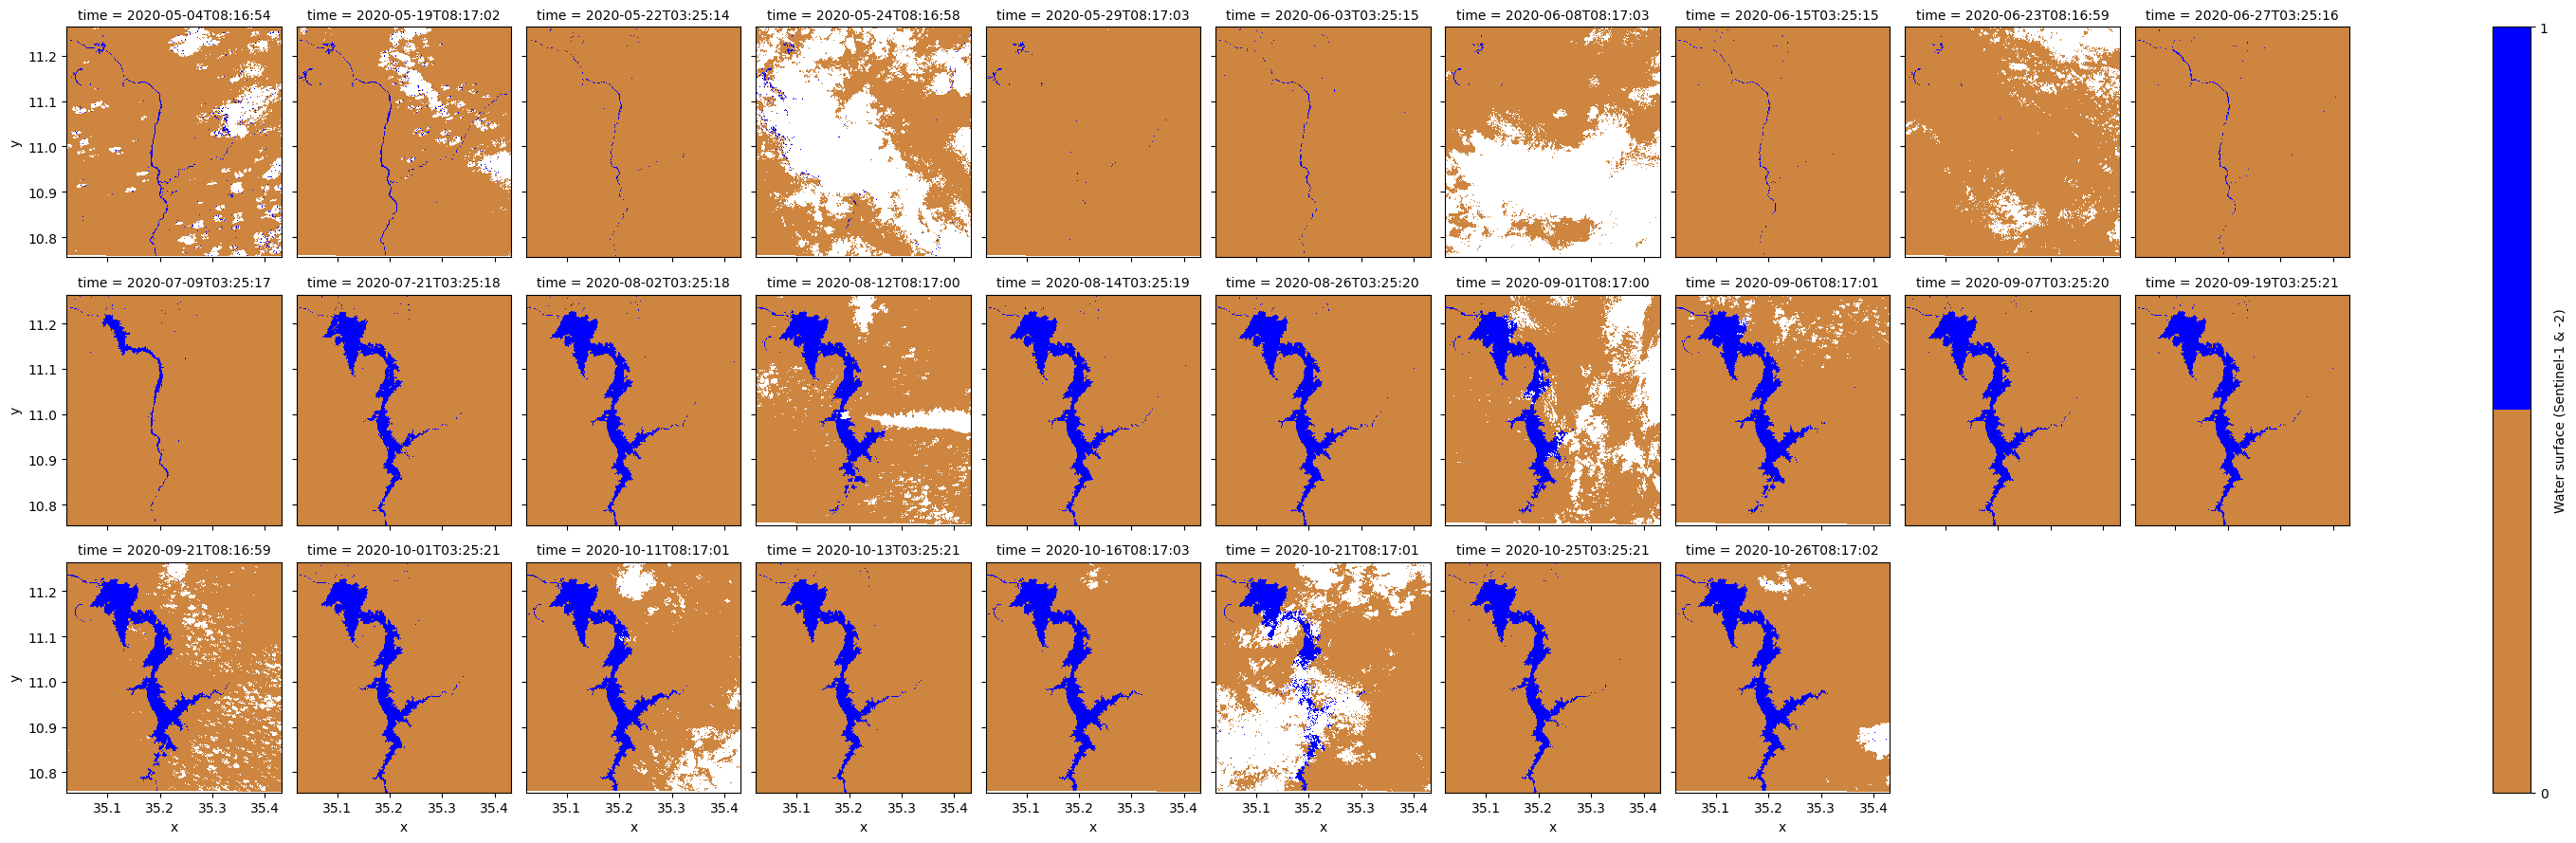

In [18]:
S_water = xr.concat([S2_water, S1_water], dim='time').sortby('time')

cmap = ListedColormap(['peru', 'blue'])
S_water.plot(col='time', col_wrap=10, cbar_kwargs={'label': 'Water surface (Sentinel-1 & -2)', 'ticks': [0, 1]}, cmap=cmap)

## Development of water surface extent over time

Now let's use this fused time series to observe the development of water surface extent. First, we eliminate NaN pixels by a sequence of gap filling operations along the time dimension: fill with nearest (temporal) neighbour, forward fill, then backward fill (*Tipp*: plot the time series after each step to see why multiple steps are applied).

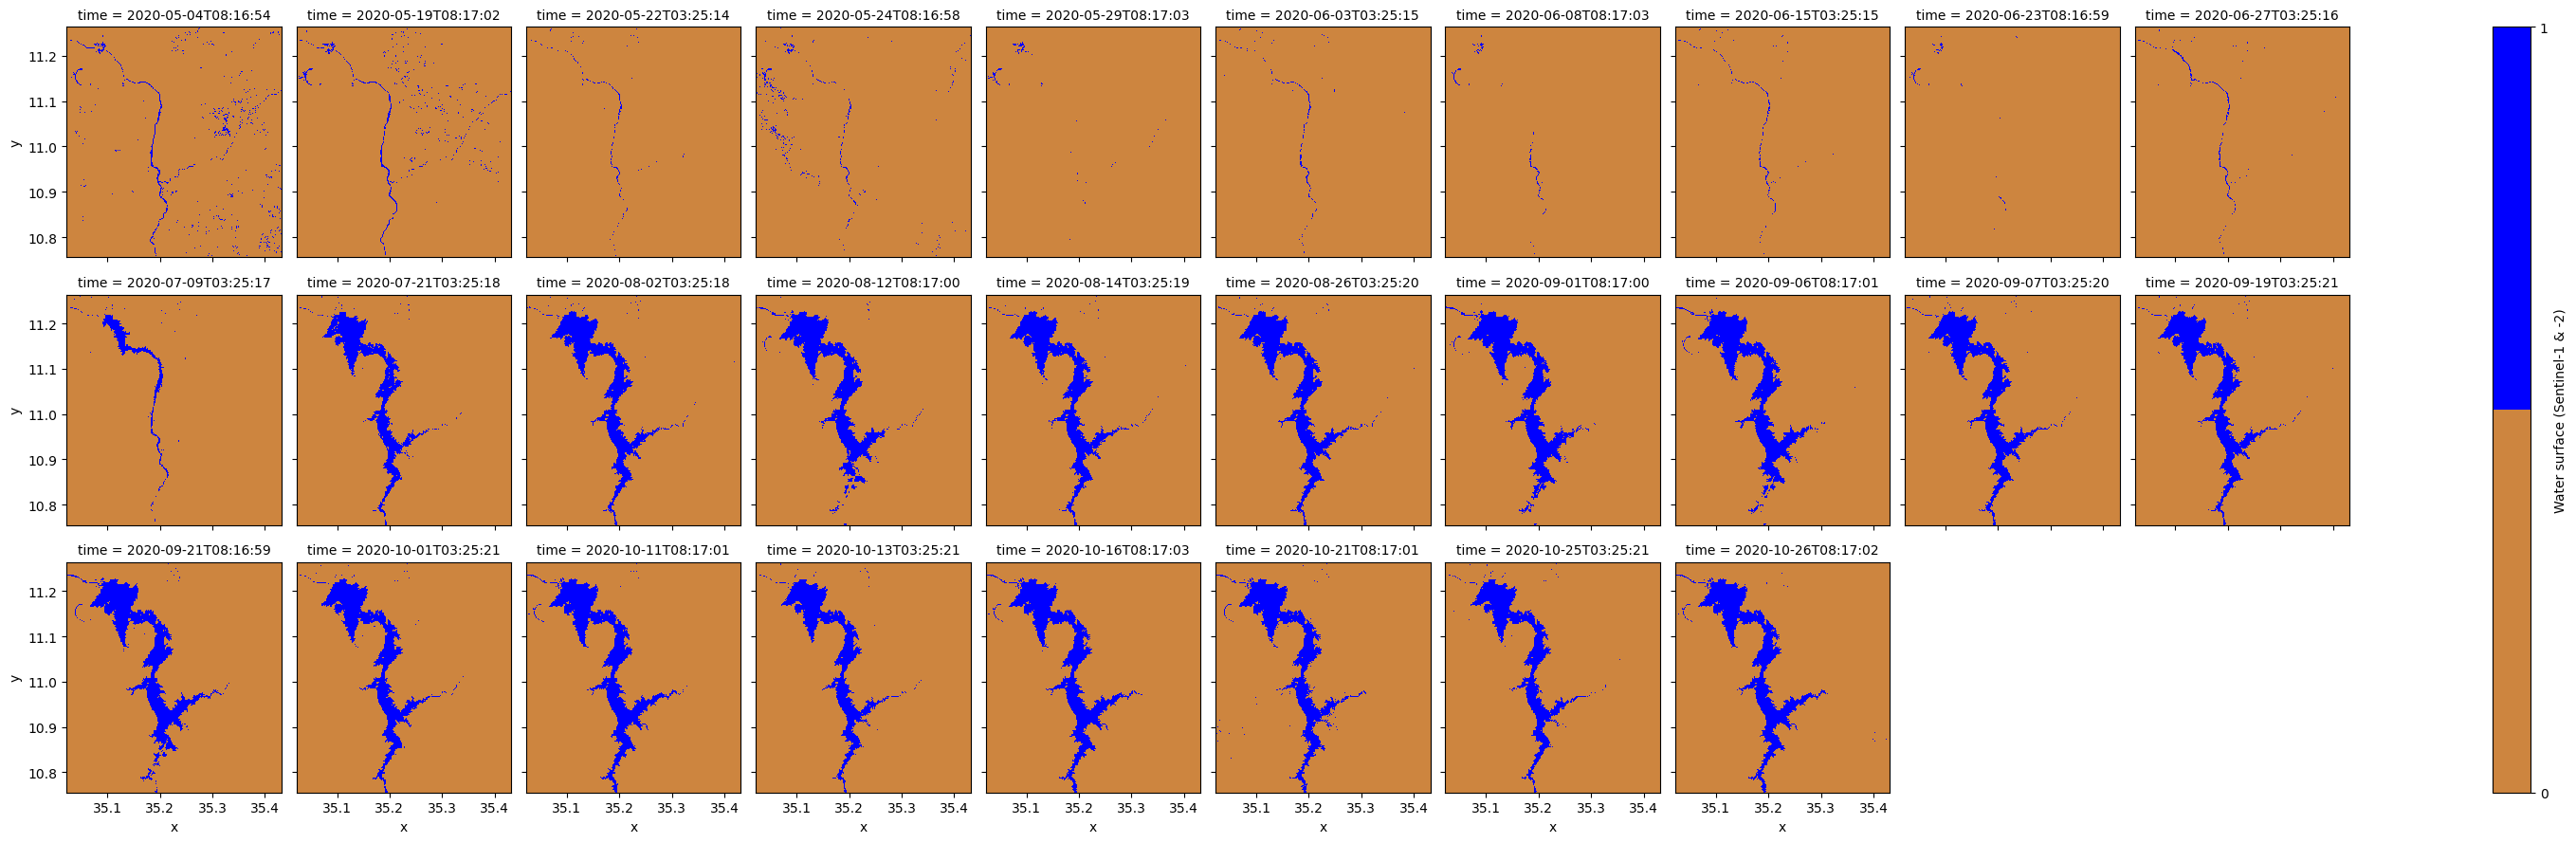

In [19]:
S_water_filled = S_water.interpolate_na(dim='time', method='nearest')   # fill with nearest neighbour
S_water_filled = S_water_filled.ffill(dim='time')                       # forward fill (requires the bottleneck package to be installed)
S_water_filled = S_water_filled.bfill(dim='time')                       # backward fill
S_water_filled.plot(col='time', col_wrap=10, cbar_kwargs={'label': 'Water surface (Sentinel-1 & -2)', 'ticks': [0, 1]}, cmap=cmap)

For comparison, add surface water extent derived from S-2 and S-1 alone. First, fill missing values.

In [20]:
# S-1
S1_water_filled = S1_water.interpolate_na(dim='time', method='nearest')
S1_water_filled = S1_water_filled.ffill(dim='time')
S1_water_filled = S1_water_filled.bfill(dim='time')

# S-2
S2_water_filled = S2_water.interpolate_na(dim='time', method='nearest')
S2_water_filled = S2_water_filled.ffill(dim='time')
S2_water_filled = S2_water_filled.bfill(dim='time')

Calculate how much of the scene (percentage) is covered by a water surface and plot this.

Text(0, 0.5, 'Water surface extent [%]')

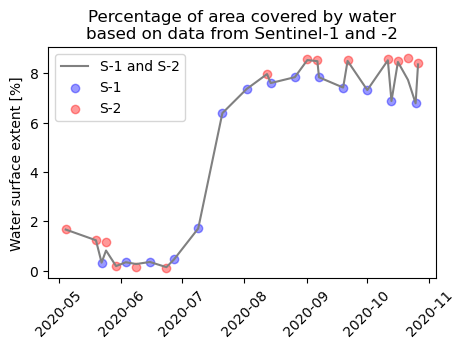

In [21]:
water_percentage = np.nanmean(S_water_filled.values, axis=(1,2))*100
S2_water_percentage = np.nanmean(S2_water_filled.values, axis=(1,2))*100
S1_water_percentage = np.nanmean(S1_water_filled.values, axis=(1,2))*100

plt.figure(figsize=(5,3))
plt.plot(S_water_filled.time, water_percentage, label='S-1 and S-2', color='grey')
plt.scatter(S1_water_filled.time, S1_water_percentage, color='blue', alpha=0.4, label='S-1')
plt.scatter(S2_water_filled.time, S2_water_percentage, color='red', alpha=0.4, label='S-2')
plt.legend()
plt.title("Percentage of area covered by water\nbased on data from Sentinel-1 and -2")
plt.xticks(rotation=45)
plt.ylabel("Water surface extent [%]")

## Conclusion

In our small case study, the (actual, i.e. usable) temporal resolution of S-2 is severely downgraded by cloud cover, especially in the time period most critical for our analysis. The temporal resolution of S-1 is much more robust in this respect (thanks to the active sensing principle and radar penetrating the clouds) but still benefits from an addition of other data. Hence, we see how the temporal resolution of a remotely sensed time series can be strongly enhanced by a fusion of data from two different sensors.

In this case, a data fusion at a lower level (such as harmonization of Landsat and Sentinel-2 optical bands or indices) would have been difficult as the sensors used here measure completely different physical quantities and, thus, cannot directly be put together. A classification of each of the two time series prior to fusing them seemed more appropriate and gave reasonable results, although the classification results might be optimized to provide a more harmonic fused time series (look at the plot above where S-1 and S-2 based water extents seem to be (systematically) diverging).